# Example 1: Compare PyRaysum with other synthetic and real data

In this example we are going to compare arrival times and amplitudes from `PyRaysum` with synthetic data from `Telewavesim` (https://paudetseis.github.io/Telewavesim/) and a real data example from station `HYB` in Hyderabad, India.

We'll use `obspy` to download and process seismic data, `numpy` to read the provided `telewavesim` output and `matplotlib` to make a comparison plot.

> **_NOTE:_** To load the data included in the PyRaysum package, you first need to install the `Examples` folder following the notes described [here](https://paudetseis.github.io/PyRaysum/init.html#usage), and execute the notebook from the Examples/notebooks/ directory.

In [1]:
import obspy
from obspy.clients.fdsn import Client
from pyraysum import prs
import matplotlib.pyplot as mp
import numpy as np

## Loading earthquake data
The event we will be looking at is an intermediate depth, magnitude 6.3 earthquake that occurred in the Philippines in 2002. The recording comes from station `HYB` in Hyderabad, India, which is located on a seismically transparent (i.e., homogeneous) cratonic crust. The earthquake arrives due east (back-azimuth equal to 90°), so that the east component in the seismogram is in the radial direction.

In [2]:
# Use the `IRIS` client
client = Client("IRIS")

# Set the origin time to search catalogue
t0 = obspy.UTCDateTime("2002-01-01T11:29:22")

# Fetch event object
event = client.get_events(
    starttime=t0,
    endtime=t0 + 1,
    minmagnitude=6.0,
    maxmagnitude=6.5,
    mindepth=100,
)[0]

# Display event information
print(event.origins[0])
print(event.magnitudes[0])

Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=3110321")
	          time: UTCDateTime(2002, 1, 1, 11, 29, 22, 720000)
	     longitude: 125.749
	      latitude: 6.282
	         depth: 140100.0
	 creation_info: CreationInfo(author='ISC')
Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=16655792")
	            mag: 6.3
	 magnitude_type: 'MW'
	  creation_info: CreationInfo(author='HRVD')


The event has a very simple P waveform that arrives just before 11:38. A few seconds later, the surface reflected pP wave arrives. Around 11:45, the S waves arrive. They are here shown only for orientation. We will only be interested in the short time interval between P and pP. 

3 Trace(s) in Stream:
G.HYB..BHZ | 2002-01-01T11:36:42.047000Z - 2002-01-01T11:47:41.997000Z | 20.0 Hz, 13200 samples
G.HYB..BHN | 2002-01-01T11:36:42.047000Z - 2002-01-01T11:47:41.997000Z | 20.0 Hz, 13200 samples
G.HYB..BHE | 2002-01-01T11:36:42.047000Z - 2002-01-01T11:47:41.997000Z | 20.0 Hz, 13200 samples


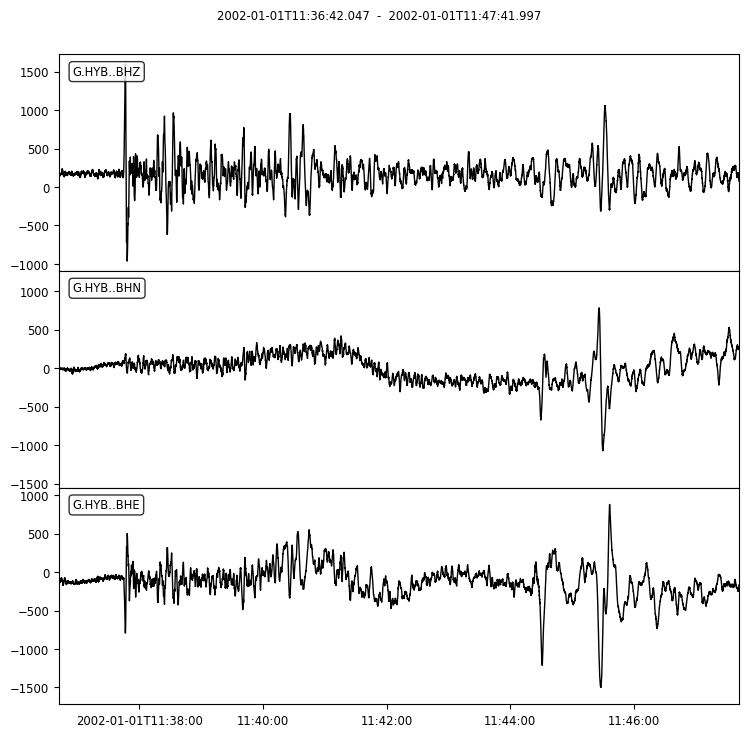

In [3]:
# Set start (t1) and end (t2) times of P-wave window
t1 = t0 + 8*60. + 20.
t2 = t0 + 8*60. + 45.

# Here we fetch and plot -1 to +10 minutes following the P-wave window start time
hybd = client.get_waveforms("G", "HYB", "", "BH?", t1 - 60, t1 + 10*60)
hybd.sort(reverse=True)
print(hybd)
_ = hybd.plot()

## Loading synthetic Telewavesim data
The Telewavesim data have been created with the same subsurface structure with `Telewavesim` (Audet et al. 2019), that computes reverberations in a stratified medium using the matrix propagator method (Thomson et al. 1997). It was created from the same subsurface model (Saul et al., 2000) that we will also be using to generate synthetic data with `pyraysum`. The incident teleseismic P wave is characterized by 90 degree back-azimuth and 0.06 s/km slowness. Note that we are here only looking at a much shorter time interval, i.e. 35 seconds of data.

3 Trace(s) in Stream:
.tws..Z | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:44.990000Z | 100.0 Hz, 4500 samples
.tws..N | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:44.990000Z | 100.0 Hz, 4500 samples
.tws..E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:44.990000Z | 100.0 Hz, 4500 samples


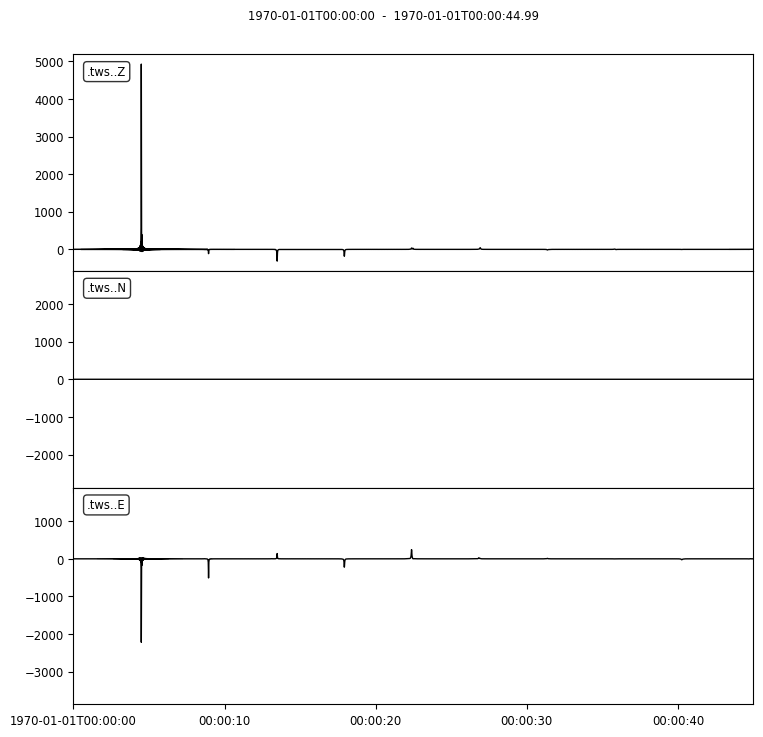

In [4]:
# Load telewavesim data
twt, twn, twe, twz = np.loadtxt("../data/telewavesim_baz090-slow006.dat", unpack=True)

# Get time interval `dt` from data
dt = twt[1] - twt[0]

# Store into Stream, switch Z component polarity and set header
twsd = obspy.Stream()
for tr, channel in zip([twz, twn, twe], ["Z", "N", "E"]):
    header = {"delta": dt, "station": "tws", "channel": channel}
    trace = obspy.Trace(tr, header=header)
    twsd.append(trace)
    
# Make simple plot
print(twsd)
_ = twsd.plot()

## Creating synthetic data with PyRaysum

We will be using the subsurface model of the Indian craton of Saul et. al (2000), which suggests a 32 km thick cratonic crust with P- and S-wave velocities of 6.55 and 3.50 km/s, repectively. In `pyraysum`, we define:

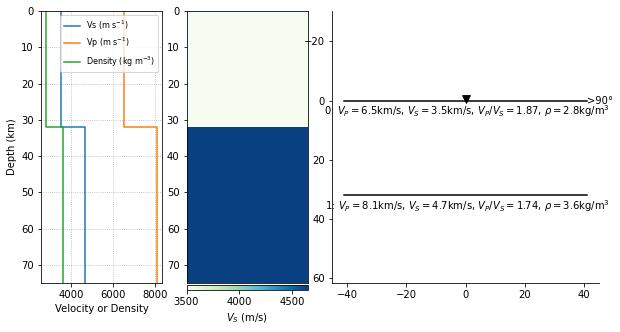

In [5]:
# Make a pyraysum model
thickn = [32000, 0]
rho = [2800, 3600]
vp = [6550, 8100]
vs = [3500, 4650]
model = prs.Model(thickn, rho, vp, vs)

# Plot model
model.plot()

We again use the incident P-wave geometry of the Philippines earthquake:

In [6]:
baz = 90
slow = 0.06
geom = prs.Geometry(baz=baz, slow=slow)

In the run control (RC) parameters, we specify that we would like to: 1) generate data in a seismometer coordinate system (east-north-up; `rot=0`), 2) include all free surface reflections (`mults=2`); 3) and use a sampling rate of 100 Hz (`dt=1/100`) with 2500 samples (`npts=2500`). This yields a 25s-long seismogram. The waveforms should not be shifted or aligned (`align=0`). Note that the unit amplitude points _toward_ the source.

In [7]:
# Set `run` parameters
ctrl = prs.Control(
    verbose=False,
    rot=0,
    mults=2,
    dt=1/100,
    npts=2500,
    align=0,
)

# Run Raysum and get seismograms
result = prs.run(model, geom, ctrl)

# Extract first (and only) ray from the result (ray index [0])
seis, rfs = result[0]
print(seis)

3 Trace(s) in Stream:
...SYZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:24.990000Z | 100.0 Hz, 2500 samples
...SYN | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:24.990000Z | 100.0 Hz, 2500 samples
...SYE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:24.990000Z | 100.0 Hz, 2500 samples


These are the synthetic seismograms. Once we calculate receiver functions, they will be strored in the second return value. Right now, this is an empty `Stream`:

In [8]:
print(rfs)

0 Trace(s) in Stream:



Let's continue working with the seismograms and make a quick plot.

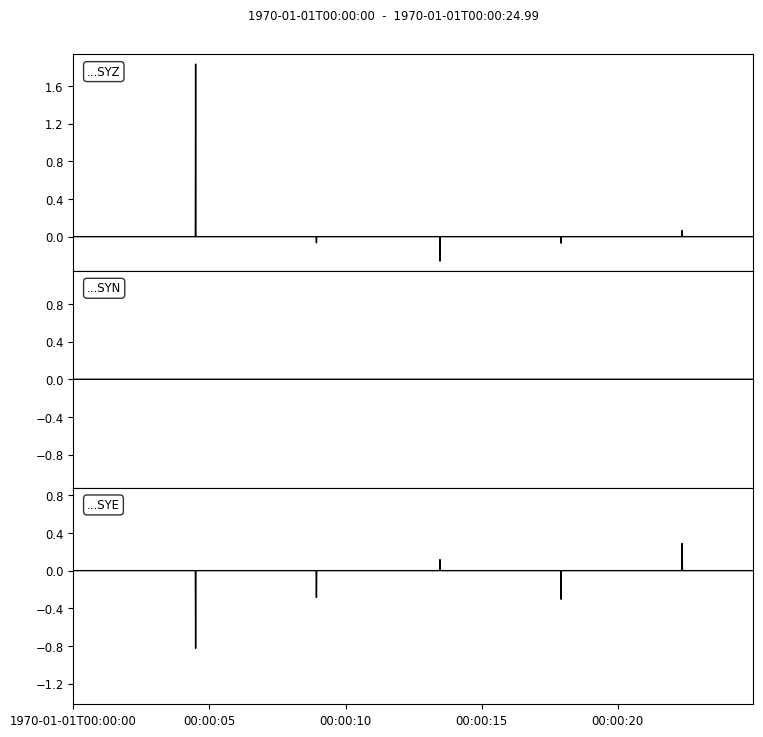

In [9]:
prsd = result[0][0]
_ = prsd.plot()

We will now pre-process all data equally. We will filter them, and align and normalize them to the maximum amplitude on the vertical component of the measured seismogram.

In [10]:
# Set frequency corners in Hz
fmin = 1./20. 
fmax = 1.

# Demean and filter all data
for dat in [hybd, twsd, prsd]:
    dat.detrend("demean")
    dat.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True)

# Extract the P-wave window in real data
hybd.trim(t1, t2)

# Index of the maximum amplitude on the vertical component of the data
imax = np.argmax(abs(hybd[0].data))

# Cycle through both synthetic data and process them equally
for trs in [prsd, twsd]:
    jmax = np.argmax(abs(trs[0].data))  # maximum vertical amplitude
    dt = hybd[0].times()[imax] - trs[0].times()[jmax]  # relative time shift of maximum
    dt0 = hybd[0].stats.starttime - trs[0].stats.starttime  # absolute time difference
    norm = hybd[0].data[imax] / trs[0].data[jmax]  # relative amplitude of vertical maximum
    for tr in trs:
        tr.stats.starttime += dt + dt0  # align peaks
        tr.data *= norm  # normalize
        tr.trim(t1, t2)  # cut around P-wave
        if tr.stats.station == "prs":
            tr.stats.phase_amplitudes *= norm

## Comparison plots
We define a function to plot the PyRaysum data against the real Hyderabad and the synthetic Telewavesim data. Note how the book-keeping infrastructure of `obspy.Trace` is used to store phase names, arrival times and amplitudes. These are used here to better interpret the seismograms.

In [11]:
def plot(data, model):
    
    lws = [4, 1]  # linewidths ...
    cols = ["darkgray", "crimson"]  # colors for data and model

    # Subplot with 3 rows
    fig, axs = mp.subplots(
        nrows=3, ncols=1, figsize=(10, 6), tight_layout=True, sharex=True, sharey=True
    )
    
    # Cycle through components
    for ax, dat, mod in zip(axs, data, model):
        trs = [dat, mod]
        
        # Cycle through data and model
        for tr, lw, col in zip(trs, lws, cols):
            ax.plot(
                tr.times(),
                tr.data,
                label=tr.stats.station + "." + tr.stats.channel,
                lw=lw,
                color=col,
            )
            
            # Write phase info
            if tr.stats.station == "prs":
                tim = np.nan
                dy = 300
                n = 1
                # Time sorted, then reverse amplitude sorted
                for pht, phn, phd, pha in sorted(
                    zip(
                        tr.stats.phase_times,
                        tr.stats.phase_names,
                        tr.stats.phase_descriptors,
                        tr.stats.phase_amplitudes,
                    ),
                    key=lambda x: (x[0], -abs(x[3])),
                ):
                    # Plot all lables opposite of largest amplitude
                    if abs(tim - pht) < 1:
                        n += 1
                        pha = amp
                    else:
                        n = 1
                    sign = -np.sign(pha)  # absolute amplitudes are here meaningless due to applied filter
                    ax.text(pht, sign*n*dy, phn, ha="center", va="center")
                    ax.text(pht, sign*3*dy + sign*n*dy, phd, ha="center", va="center")
                    tim = pht
                    amp = pha

        ax.legend(frameon=False)
        ax.set_axis_off()
        
    # Only plot lowermost time axes
    ax.set_axis_on()
    ax.spines[["top", "left", "right", "bottom"]].set_visible(False)
    ax.set_yticks([])
    ax.set_xlabel("Time(s)")

    return fig

### Comparison with real data

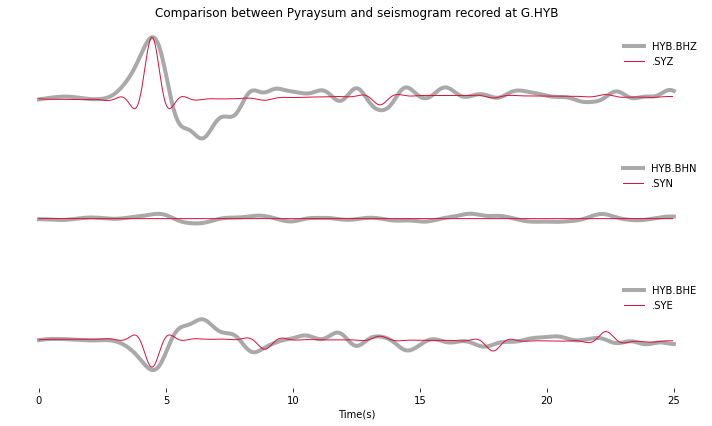

In [12]:
fig = plot(hybd, prsd)
_ = fig.suptitle("Comparison between Pyraysum and seismogram recored at G.HYB")

The comparison with the real data shows that some complexity of the P-wave train can, in this simple example, be attributed to conversions and reflections of the seismic wave field in the cratonic crust. The long phase descriptors consist of layer numbers and phase letters.

> Note: Read for example "**1P0P0s0S**" as: A wave that travels through layer **1** as an **upgoing P**-wave, layer **0** as an **upgoing P**-wave, gets reflected, travels through layer **0** as a **downgoing S**-wave, gets again reflected and finally travels through layer **0** as an **upgoing S**-wave". The timing and amplitude of such reverberations will be used in example 3 to invert for subsurface properties instead of assuming them, as we did here.

### Comparison with synthetic data

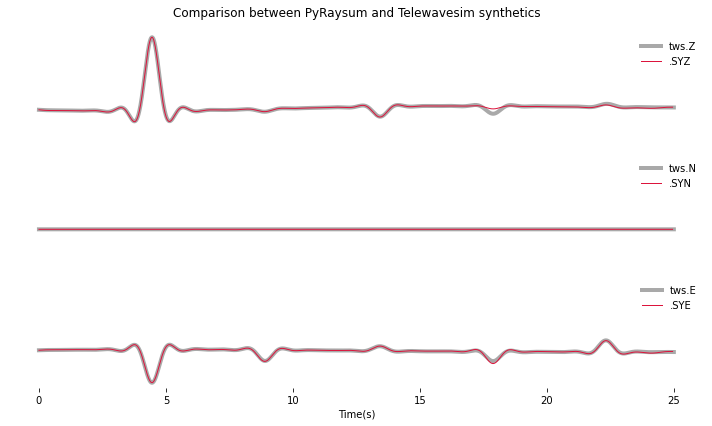

In [13]:
fig = plot(twsd, prsd)
_ = fig.suptitle("Comparison between PyRaysum and Telewavesim synthetics")

The comparison with synthetic data from Telewavesim shows a good match of the major phases. Note that the data need to be filtered, because raw telewavesim data suffer from aliasing at infinite frequencies.

## Computing equivalent phases
The amplitude of the *PpS* phase is apparently overestimated on the E component and underestimated on the Z component. This is the case, because the RC parameter `mults=2` only computes first-order multiples, i.e. reflections of the direct *P* wave. Reflections from *PS* are missing, most notably *PSpP*. To address this problem, we will next use the `RC.set_phaselist()` method to explicitly name the phases we wish to compute. The method implicitly sets `mults=3`. `Result` has a dedicated method `descriptors()` to list unique phases present in the synthetic waveforms.

In [14]:
phl = result.descriptors()
eqp = prs.equivalent_phases(phl)
print("Phases computed with mult=2:")
print(phl)
print()
print("Dynamically equivalent phases:")
print(eqp)

Phases computed with mult=2:
['1P0P', '1P0P0p0P', '1P0P0p0S', '1P0P0s0S', '1P0S']

Dynamically equivalent phases:
['1P0P0s0P', '1P0S0p0P', '1P0S0p0S', '1P0S0s0P']


We will now set a phaselist that includes these phases using the `equivalent` option of `set_phaselist`.

In [15]:
ctrl.set_phaselist(phl, equivalent=True)

And run *PyRaysum* and the post processing again:

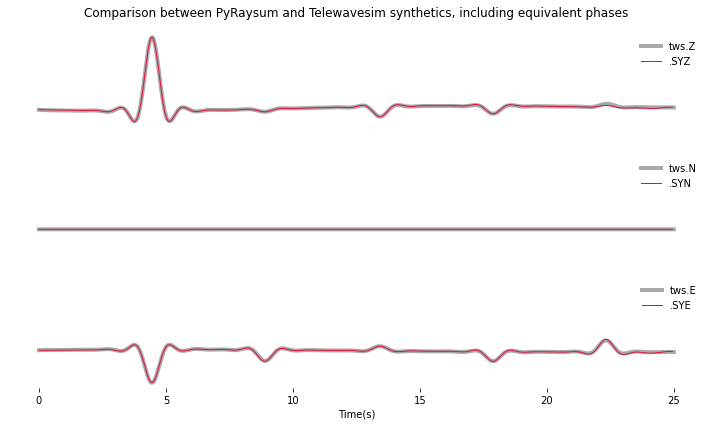

In [16]:
# Run Raysum and get seismograms
result = prs.run(model, geom, ctrl)

prsd = result[0][0]
prsd.filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True)

jmax = np.argmax(abs(prsd[0].data))  # maximum vertical amplitude
dt = hybd[0].times()[imax] - prsd[0].times()[jmax]  # relative time shift of maximum
dt0 = hybd[0].stats.starttime - prsd[0].stats.starttime  # absolute time difference
norm = hybd[0].data[imax] / prsd[0].data[jmax]  # relative amplitude of vertical maximum
for tr in prsd:
    tr.stats.starttime += dt + dt0  # align peaks
    tr.data *= norm  # normalize
    tr.trim(t1, t2)  # cut around P-wave
    if tr.stats.station == "prs":
        tr.stats.phase_amplitudes *= norm
        
fig = plot(twsd, prsd)
_ = fig.suptitle("Comparison between PyRaysum and Telewavesim synthetics, including equivalent phases")

The amplitudes of the reflected phases are now better matched. To explore the actual amplitude contributions of the equivalent phases, we look them up in the metadata of the synthetic seismic trace:

In [17]:
print("Name, Time, Amplitude")
f = "{:4s}  {:>4.1f}    {:>7.3f}"
stats = prsd[0].stats
for t, a, n in sorted(zip(stats.phase_times, stats.phase_amplitudes, stats.phase_names)):
    print(f.format(n, t, a))

Name, Time, Amplitude
P      4.5      1.830
PS     8.9     -0.065
PpP   13.5     -0.259
PsP   17.9     -0.153
PpS   17.9     -0.069
PSpP  17.9      0.020
PSsP  22.4     -0.024
PSpS  22.4      0.005
PsS   22.4      0.065


## Conclusion

This example demonstrated how `PyRaysum` can be used to compute the timing and amplitude of P-wave energy converted and reflected at the base of a cratonic crust. We compared the modelling results with a real data example from the Indian craton and a synthetic example that has been generated with an independent waveform simulation method.

## References

* Audet, P., Thomson, C.J., Bostock, M.G., and Eulenfeld, T. (2019). Telewavesim: Python software for teleseismic body wave modeling. Journal of Open Source Software, 4(44), 1818, https://doi.org/10.21105/joss.01818

* Saul, J., Kumar, M. R., & Sarkar, D. (2000). Lithospheric and upper mantle structure of the Indian Shield, from teleseismic receiver functions. Geophysical Research Letters, 27(16), 2357-2360. https://doi.org/10.1029/1999GL011128

* Thomson, C.J. (1997). Modelling surface waves in anisotropic structures: I. Theory. Physics of the Earth and Planetary interiors, 103, 195-206. https://doi.org/10.1016/S0031-9201(97)00033-2